# AutoML: Automated Machine Learning Tutorial

<!--<badge>--><a href="https://colab.research.google.com/github/kuennethgroup/ml_in_ms_wt24/blob/main/wt_25_ml_in_ms/08_ex/autoML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a><!--</badge>-->

## Introduction

This tutorial introduces Automated Machine Learning (AutoML), a technique that automates the process of applying machine learning to real-world problems. AutoML handles tasks like feature selection, model selection, hyperparameter tuning, and model evaluation automatically.

In this tutorial, we will:

1. Learn about AutoML using the AutoGluon framework
2. Work with a materials science dataset on polymer tendency to crystallize
3. Compare different ML models automatically generated by AutoML
4. Evaluate model performance using standard metrics

## Dataset

We'll use a polymer dataset that contains molecular fingerprints and crystallization tendency values. The goal is to predict the tendency of a polymer to crystallize based on its molecular features.

In [1]:
# Import libraries and load the dataset
import pandas as pd

# Load the polymer crystallization dataset from GitHub
df_ = pd.read_json(
    "https://raw.githubusercontent.com/kuennethgroup/materials_datasets/refs/heads/main/polymer_tendency_to_crystalize/polymers_tend_to_crystalize.json"
)

# Display the first few rows to understand the data structure
print(f"Dataset shape: {df_.shape}")
df_

Dataset shape: (432, 4)


,smiles,property,value,fingerprint
0,[*]C[*],Xc,47.80,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,[*]CC([*])C,Xc,44.47,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,[*]CC([*])CC,Xc,34.04,"[1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,[*]CC([*])CCC,Xc,20.01,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,[*]CC([*])CC(C)C,Xc,21.64,"[0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
...,...,...,...,...
427,[*]C([*])(F)F,Xc,31.84,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
428,[*]C/C=C\C[*],Xc,25.58,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
429,[*]O[Si](C)(C)CCCC(=O)Oc1ccc(C=Nc2ccc(N=Cc3ccc...,Xc,29.05,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ..."
430,[*]O[Si](C)(C)CCCC(=O)Oc1ccc(C=Nc2ccc(Cc3ccc(N...,Xc,21.74,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ..."


## Understanding the Dataset

The dataset contains the following columns:
- `property`: The name of the property being measured (crystallization tendency)
- `smiles`: The SMILES representation of the polymer structure
- `value`: The numerical value representing crystallization tendency (our target variable)
- `fingerprint`: Molecular fingerprints (numerical representations of molecular structures)

Let's examine the data types and prepare our dataset for modeling.

In [2]:
# Examine the data structure
print("Data types:")
print(df_.dtypes)

# Drop unnecessary columns
# We'll keep only the value (target) and fingerprint (features)
df_prep = df_.drop(columns=["property", "smiles"])
df_prep.head()

Data types:
smiles          object
property        object
value          float64
fingerprint     object
dtype: object


,value,fingerprint
0,47.80,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,44.47,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,34.04,"[1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,20.01,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,21.64,"[0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


## Data Preparation

The fingerprint column contains arrays of numerical values that represent molecular features. We need to convert these arrays into individual columns for our machine learning models.

In [3]:
import numpy as np

# Extract the target variable
df = df_prep["value"].to_frame()

# Convert the fingerprint arrays into individual columns
# Each element in the fingerprint becomes a feature column
df = pd.concat((df, pd.DataFrame(np.vstack(df_prep["fingerprint"]))), axis=1)

# Show the transformed dataset
print(f"Transformed dataset shape: {df.shape}")
print(f"Number of features: {df.shape[1] - 1}")  # -1 for the target column
df.head()

Transformed dataset shape: (432, 2049)
Number of features: 2048


,value,0,1,2,3,4,5,6,7,8,...,2038,2039,2040,2041,2042,2043,2044,2045,2046,2047
0,47.80,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,44.47,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,34.04,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,20.01,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,21.64,0,2,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Train-Test Split

Before building our models, we'll split the data into training and testing sets to properly evaluate the model performance.

In [4]:
from sklearn.model_selection import train_test_split

# Split the data into training (80%) and testing (20%) sets
# Using a fixed random_state for reproducibility
df_train, df_test = train_test_split(df, test_size=0.20, random_state=42)

# Show the shapes of the original, training, and testing datasets
print(f"Total dataset: {len(df)} samples")
print(f"Training set: {len(df_train)} samples ({len(df_train)/len(df)*100:.1f}%)")
print(f"Testing set: {len(df_test)} samples ({len(df_test)/len(df)*100:.1f}%)")

Total dataset: 432 samples
Training set: 345 samples (79.9%)
Testing set: 87 samples (20.1%)


## AutoML with AutoGluon

AutoGluon is a powerful AutoML library that automatically trains and tunes a diverse set of machine learning models. It performs:

1. **Feature engineering**: Automatically handling missing values, encoding categorical features, etc.
2. **Model selection**: Testing various algorithms like Random Forest, XGBoost, Neural Networks, etc.
3. **Hyperparameter tuning**: Finding optimal parameters for each model
4. **Model ensembling**: Combining multiple models for better performance

Let's prepare our data for AutoGluon:

In [5]:
from autogluon.tabular import TabularDataset, TabularPredictor

# Convert our pandas DataFrames to AutoGluon's TabularDataset format
train_data = TabularDataset(df_train)
test_data = TabularDataset(df_test)

print("Training data:")
display(train_data.head())

print("\nTesting data:")
display(test_data.head())

Training data:


,value,0,1,2,3,4,5,6,7,8,...,2038,2039,2040,2041,2042,2043,2044,2045,2046,2047
132,57.62,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
231,28.37,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
31,21.61,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
84,79.99,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
296,0.37,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0



Testing data:


,value,0,1,2,3,4,5,6,7,8,...,2038,2039,2040,2041,2042,2043,2044,2045,2046,2047
424,8.38,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
75,72.53,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
180,53.05,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
30,16.73,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
392,38.13,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Training Models with AutoML

Now we'll use AutoGluon to automatically train and tune multiple machine learning models. We'll specify:

- The target column (`label`)
- The problem type (regression)
- Time limit for training
- Quality preset (determines how many models are tried and how extensively)

The `fit()` method will handle the rest!

In [6]:
# Train models using AutoGluon
predictor = TabularPredictor(
    label="value",  # Our target column
    problem_type="regression",  # We're predicting a continuous value
).fit(
    train_data,
    time_limit=80,  # Limit training time to 80 seconds
    presets="good_quality",  # Use high-quality preset for better models
)

# Note: The "good_quality" preset enables more models and more extensive hyperparameter tuning
# Other options include: "best_quality", "good_quality", "medium_quality", etc.
# See: https://auto.gluon.ai/stable/tutorials/tabular/tabular-essentials.html#presets

print("Training complete!")

No path specified. Models will be saved in: "AutogluonModels/ag-20250625_085548"
Verbosity: 2 (Standard Logging)
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.12.8
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #140-Ubuntu SMP Wed Dec 18 17:59:53 UTC 2024
CPU Count:          192
Memory Avail:       901.78 GB / 1007.45 GB (89.5%)
Disk Space Avail:   1513.42 GB / 7096.34 GB (21.3%)
Presets specified: ['good_quality']
Setting dynamic_stacking from 'auto' to True. Reason: Enable dynamic_stacking when use_bag_holdout is disabled. (use_bag_holdout=False)
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=8, num_bag_sets=1
Note: `save_bag_folds=False`! This will greatly reduce peak disk usage during fit (by ~8x), but runs the risk of an out-of-memory error during model refit if memory is small relative to the data size.
	You can avoid this risk by setting `save_bag_folds=True`.
DyStack is enabl

(_ray_fit pid=8497) [1000]	valid_set's rmse: 13.4164


(_dystack pid=4156447) 	-18.6573	 = Validation score   (-root_mean_squared_error)
(_dystack pid=4156447) 	1.08s	 = Training   runtime
(_dystack pid=4156447) 	0.03s	 = Validation runtime
(_dystack pid=4156447) Fitting model: LightGBM_BAG_L1 ... Training model for up to 6.90s of the 11.68s of remaining time.
(_dystack pid=4156447) 	Fitting 8 child models (S1F1 - S1F8) | Fitting with ParallelLocalFoldFittingStrategy (8 workers, per: cpus=24, gpus=0, memory=0.02%)
(_dystack pid=4156447) 	-19.1182	 = Validation score   (-root_mean_squared_error)
(_dystack pid=4156447) 	0.89s	 = Training   runtime
(_dystack pid=4156447) 	0.03s	 = Validation runtime
(_dystack pid=4156447) Fitting model: RandomForestMSE_BAG_L1 ... Training model for up to 4.42s of the 9.20s of remaining time.
(_dystack pid=4156447) 	-19.357	 = Validation score   (-root_mean_squared_error)
(_dystack pid=4156447) 	0.65s	 = Training   runtime
(_dystack pid=4156447) 	0.11s	 = Validation runtime
(_dystack pid=4156447) Fitting model

(_ray_fit pid=95055) [1000]	valid_set's rmse: 18.0052


(_dystack pid=4156447) 	-18.7711	 = Validation score   (-root_mean_squared_error)
(_dystack pid=4156447) 	1.39s	 = Training   runtime
(_dystack pid=4156447) 	0.03s	 = Validation runtime
(_dystack pid=4156447) Fitting model: LightGBM_BAG_L2 ... Training model for up to 0.89s of the 0.89s of remaining time.
(_dystack pid=4156447) 	Fitting 8 child models (S1F1 - S1F8) | Fitting with ParallelLocalFoldFittingStrategy (8 workers, per: cpus=24, gpus=0, memory=0.02%)
(_ray_fit pid=111584) 	Ran out of time, early stopping on iteration 656. Best iteration is:
(_ray_fit pid=111584) 	[651]	valid_set's rmse: 18.4613
(_ray_fit pid=50673) 	Ran out of time, early stopping on iteration 650. [repeated 5x across cluster] (Ray deduplicates logs by default. Set RAY_DEDUP_LOGS=0 to disable log deduplication, or see https://docs.ray.io/en/master/ray-observability/user-guides/configure-logging.html#log-deduplication for more options.)
(_dystack pid=4156447) 	-18.8231	 = Validation score   (-root_mean_squared_

Training complete!


## Evaluating Model Performance

Now that we've trained our models, let's evaluate their performance on the test set. We'll:

1. Generate predictions on our test data
2. Calculate common regression metrics (RMSE and R²)
3. Visualize actual vs. predicted values

/home/chris/courses/ml-in-ms-st25/.venv/lib/python3.12/site-packages/fastai/learner.py:455: UserWarning: load_learner` uses Python's insecure pickle module, which can execute malicious arbitrary code when loading. Only load files you trust.
If you only need to load model weights and optimizer state, use the safe `Learner.load` instead.
  warn("load_learner` uses Python's insecure pickle module, which can execute malicious arbitrary code when loading. Only load files you trust.\nIf you only need to load model weights and optimizer state, use the safe `Learner.load` instead.")


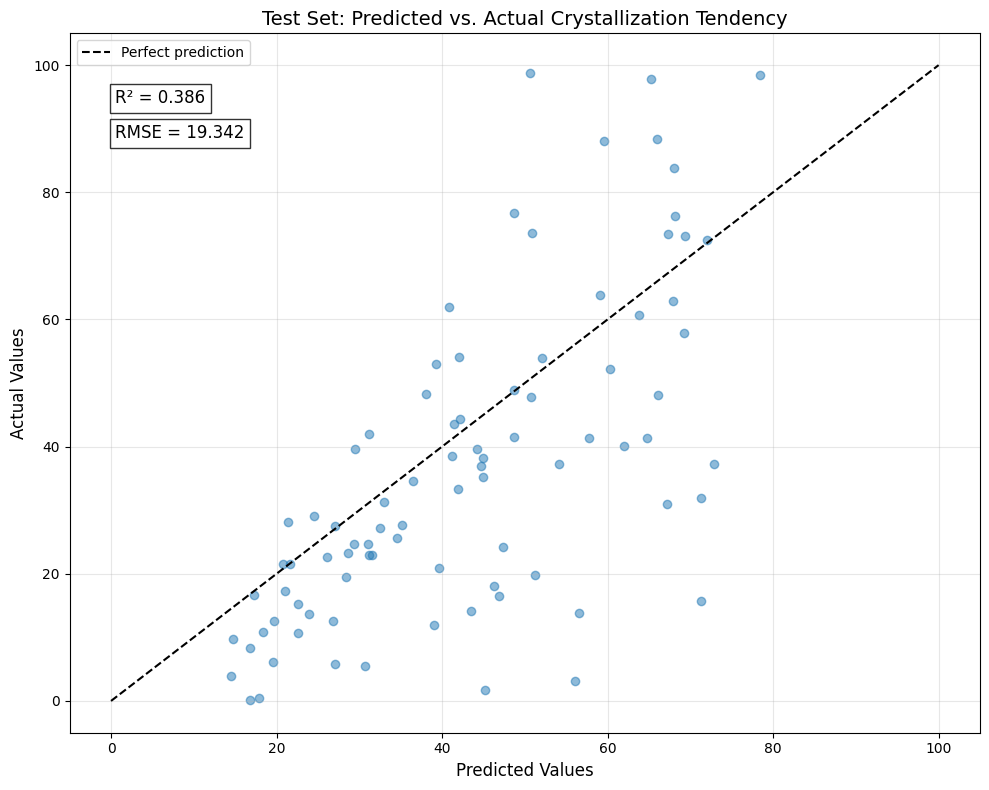

R² Score: 0.3859 (higher is better, 1.0 is perfect)
RMSE: 19.3416 (lower is better, 0.0 is perfect)


In [7]:
import matplotlib.pyplot as plt
from sklearn.metrics import root_mean_squared_error, r2_score

# Create a visualization of actual vs. predicted values
fig, ax = plt.subplots(figsize=(10, 8))

# Generate predictions on the test set
y_pred = predictor.predict(test_data.drop(columns=["value"]))
y_true = test_data["value"]

# Calculate performance metrics
rmse = root_mean_squared_error(y_true, y_pred)
r2 = r2_score(y_true, y_pred)

# Plot actual vs. predicted values
ax.scatter(y_pred, y_true, alpha=0.5)
ax.plot([0, 100], [0, 100], "k--", label="Perfect prediction")

# Add metric annotations
ax.text(
    0.05,
    0.9,
    f"R² = {r2:.3f}",
    transform=ax.transAxes,
    fontsize=12,
    bbox=dict(facecolor="white", alpha=0.8),
)
ax.text(
    0.05,
    0.85,
    f"RMSE = {rmse:.3f}",
    transform=ax.transAxes,
    fontsize=12,
    bbox=dict(facecolor="white", alpha=0.8),
)

# Add labels and title
ax.set_title("Test Set: Predicted vs. Actual Crystallization Tendency", fontsize=14)
ax.set_ylabel("Actual Values", fontsize=12)
ax.set_xlabel("Predicted Values", fontsize=12)
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"R² Score: {r2:.4f} (higher is better, 1.0 is perfect)")
print(f"RMSE: {rmse:.4f} (lower is better, 0.0 is perfect)")

## Understanding the Model Leaderboard

One of the major benefits of AutoML is that it tries multiple models and ranks them by performance. Let's examine the leaderboard to see which models performed best:

In [8]:
# Show the leaderboard of all models trained by AutoGluon
leaderboard = predictor.leaderboard(test_data)
display(leaderboard)

# Get information about the best model
best_model = leaderboard.iloc[0]["model"]
print(f"\nBest performing model: {best_model}")

# Get feature importance if available (works for some model types)
try:
    importance = predictor.feature_importance(test_data)
    print("\nTop 10 most important features:")
    display(importance.head(10))
except:
    print("\nFeature importance not available for this model type")

/home/chris/courses/ml-in-ms-st25/.venv/lib/python3.12/site-packages/fastai/learner.py:455: UserWarning: load_learner` uses Python's insecure pickle module, which can execute malicious arbitrary code when loading. Only load files you trust.
If you only need to load model weights and optimizer state, use the safe `Learner.load` instead.
  warn("load_learner` uses Python's insecure pickle module, which can execute malicious arbitrary code when loading. Only load files you trust.\nIf you only need to load model weights and optimizer state, use the safe `Learner.load` instead.")


,model,score_test,score_val,eval_metric,pred_time_test,pred_time_val,fit_time,pred_time_test_marginal,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,WeightedEnsemble_L2_FULL,-18.349798,NaN,root_mean_squared_error,0.261975,NaN,5.976656,0.001974,NaN,0.009593,2,True,24
1,LightGBM_BAG_L1_FULL,-18.646686,NaN,root_mean_squared_error,0.020360,NaN,0.613156,0.020360,NaN,0.613156,1,True,17
2,CatBoost_BAG_L1_FULL,-18.655791,NaN,root_mean_squared_error,0.026905,NaN,1.073183,0.026905,NaN,1.073183,1,True,19
3,CatBoost_BAG_L2_FULL,-18.827901,NaN,root_mean_squared_error,0.427677,NaN,9.061599,0.027284,NaN,0.735244,2,True,28
4,ExtraTreesMSE_BAG_L1_FULL,-18.832202,NaN,root_mean_squared_error,0.057180,0.111965,0.745788,0.057180,0.111965,0.745788,1,True,20
5,ExtraTreesMSE_BAG_L1,-18.832202,-19.015966,root_mean_squared_error,0.061879,0.111965,0.745788,0.061879,0.111965,0.745788,1,True,5
6,ExtraTreesMSE_BAG_L2_FULL,-18.876572,NaN,root_mean_squared_error,0.466024,NaN,8.879183,0.065631,0.099574,0.552829,2,True,29
7,RandomForestMSE_BAG_L1,-18.984090,-19.027544,root_mean_squared_error,0.057920,0.110477,0.634167,0.057920,0.110477,0.634167,1,True,3
8,RandomForestMSE_BAG_L1_FULL,-18.984090,NaN,root_mean_squared_error,0.058716,0.110477,0.634167,0.058716,0.110477,0.634167,1,True,18
9,LightGBMXT_BAG_L1_FULL,-19.174944,NaN,root_mean_squared_error,0.035028,NaN,0.896542,0.035028,NaN,0.896542,1,True,16


These features in provided data are not utilized by the predictor and will be ignored: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 20


Best performing model: WeightedEnsemble_L2_FULL

Feature importance not available for this model type


## Conclusion

In this tutorial, we've learned how to:

1. Use AutoML to automatically build machine learning models
2. Prepare a materials science dataset for machine learning
3. Train multiple models with minimal code using AutoGluon
4. Evaluate model performance using standard metrics
5. Interpret model results and compare different algorithms

AutoML is a powerful approach for quickly developing baseline models and can often achieve competitive performance with minimal effort.

## Exercises

1. **Hyperparameter Exploration**: Try different time limits (e.g., 30s, 120s, 300s) and presets (e.g., 'medium_quality', 'best_quality') and compare the results.

2. **Feature Engineering**: Apply some scaling to the features (MinMax, RobustScaler from scikit-learn) before feeding them into AutoGluon and see if it improves performance.

3. **Cross-Validation**: Modify the code to use cross-validation instead of a single train-test split.
